如何利用MetaGPT从0开始实现一个自己的订阅智能体，定时收集网页信息，将信息汇总然后自动发送到微信。

独立实现对Github Trending(https://github.com/trending)页面的爬取，并获取每一个项目的 名称、URL链接、描述

练习怎样用MetaGPT将订阅智能体的主要组成部分串起来：

订阅智能体的主要组成部分：

定时器：定时触发订阅任务

订阅信息的获取和总结：爬虫 + 大模型

callback：经过总结的信息通过回调，给第三方发消息（微信、邮箱等）

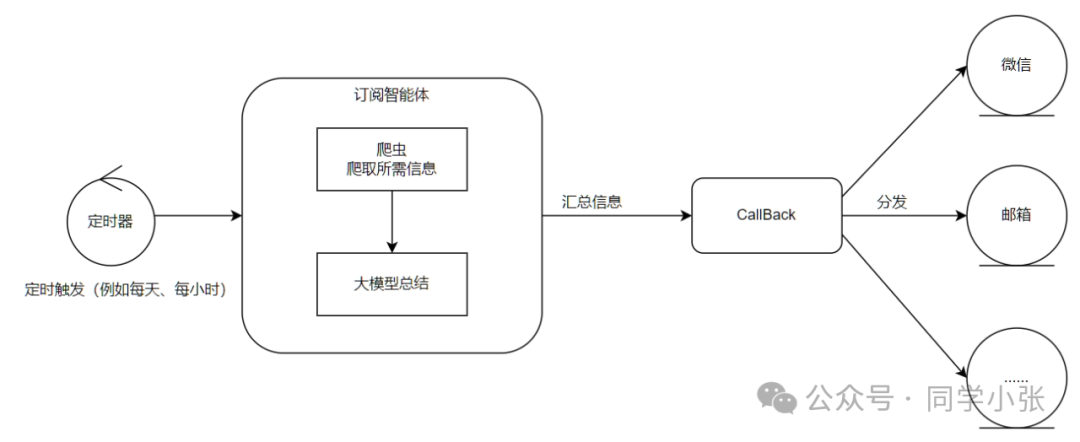

完整代码及细节注释

In [ ]:
# 加载 .env 到环境变量
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

import asyncio
from metagpt.subscription import SubscriptionRunner
from metagpt.roles import Searcher
from metagpt.schema import Message

import aiohttp
from bs4 import BeautifulSoup
from metagpt.actions.action import Action
from metagpt.logs import logger

# 1. Action1，爬虫，爬取 GitHub Trending 页面
class CrawlOSSTrending(Action):
    """
    爬取 GitHub Trending 页面
    """

    async def run(self, url: str = "https://github.com/trending"):
        async with aiohttp.ClientSession() as client:
            # async with client.get(url, proxy=CONFIG.global_proxy) as response:
            async with client.get(url) as response: # 1.1 我这里直接就能访问github，所以不需要设置代理
                response.raise_for_status()
                html = await response.text()
        # logger.debug(html)

        soup = BeautifulSoup(html, 'html.parser')

        repositories = []

        ## 1.2 解析Html页面元素，获取我们想要的数据：项目名称、url、描述、编程语言、star数量、fork数量
        for article in soup.select('article.Box-row'):
            repo_info = {}

            repo_info['name'] = article.select_one('h2 a').text.strip().replace("\n", "").replace(" ", "")
            repo_info['url'] = "https://github.com" + article.select_one('h2 a')['href'].strip()

            # Description
            description_element = article.select_one('p')
            repo_info['description'] = description_element.text.strip() if description_element else None

            # Language
            language_element = article.select_one('span[itemprop="programmingLanguage"]')
            repo_info['language'] = language_element.text.strip() if language_element else None

            # Stars and Forks
            stars_element = article.select('a.Link--muted')[0]
            forks_element = article.select('a.Link--muted')[1]
            repo_info['stars'] = stars_element.text.strip()
            repo_info['forks'] = forks_element.text.strip()

            # Today's Stars
            today_stars_element = article.select_one('span.d-inline-block.float-sm-right')
            repo_info['today_stars'] = today_stars_element.text.strip() if today_stars_element else None

            repositories.append(repo_info)

        return repositories


from typing import Any
from metagpt.actions.action import Action

TRENDING_ANALYSIS_PROMPT = """# Requirements
You are a GitHub Trending Analyst, aiming to provide users with insightful and personalized recommendations based on the latest
GitHub Trends. Based on the context, fill in the following missing information, generate engaging and informative titles,
ensuring users discover repositories aligned with their interests.

# The title about Today's GitHub Trending
## Today's Trends: Uncover the Hottest GitHub Projects Today! Explore the trending programming languages and discover key domains capturing developers' attention. From ** to **, witness the top projects like never before.
## The Trends Categories: Dive into Today's GitHub Trending Domains! Explore featured projects in domains such as ** and **. Get a quick overview of each project, including programming languages, stars, and more.
## Highlights of the List: Spotlight noteworthy projects on GitHub Trending, including new tools, innovative projects, and rapidly gaining popularity, focusing on delivering distinctive and attention-grabbing content for users.
---
# Format Example
# [Title]

## Today's Trends
Today, ** and ** continue to dominate as the most popular programming languages. Key areas of interest include **, ** and **.
The top popular projects are Project1 and Project2.

## The Trends Categories
1. Generative AI
    - [Project1](https://github/xx/project1): [detail of the project, such as star total and today, language, ...]
    - [Project2](https://github/xx/project2): ...
...

## Highlights of the List
1. [Project1](https://github/xx/project1): [provide specific reasons why this project is recommended].
...

---
# Github Trending
{trending}
"""

## 2. 总结爬取到的信息，其实就是 prompt + 爬取到的信息，丢给大模型然后获取结果
class AnalysisOSSTrending(Action):

    async def run(
        self,
        trending: Any
    ):
        return await self._aask(TRENDING_ANALYSIS_PROMPT.format(trending=trending))

from metagpt.roles import Role
## 3. 定义role，初始化上面的两个action，按顺序执行
class OssWatcher(Role):
    def __init__(
        self,
        name="Codey",
        profile="OssWatcher",
        goal="Generate an insightful GitHub Trending analysis report.",
        constraints="Only analyze based on the provided GitHub Trending data.",
    ):
        super().__init__(name, profile, goal, constraints)
        self._init_actions([CrawlOSSTrending, AnalysisOSSTrending]) ## 3.1 初始化两个action
        self._set_react_mode(react_mode="by_order") ## 3.2 按顺序执行

    async def _act(self) -> Message:
        logger.info(f"{self._setting}: ready to {self._rc.todo}")
        todo = self._rc.todo

        msg = self.get_memories(k=1)[0] # 3.4 获取最新的一条memory，爬完后的数据存在里面供分析action使用
        result = await todo.run(msg.content)

        msg = Message(content=str(result), role=self.profile, cause_by=type(todo))
        self._rc.memory.add(msg)    # 3.3 第一个action执行完，把结果存入memory
        return msg

##============================ 以上为智能体定义 =================================================


from pydantic import BaseModel, Field
import time
# Trigger
class OssInfo(BaseModel):
    url: str
    timestamp: float = Field(default_factory=time.time)

from typing import Optional
from pytz import BaseTzInfo
from aiocron import crontab

## 4. 定时器的实现，用crontab库实现
class GithubTrendingCronTrigger():

    def __init__(self, spec: str, tz: Optional[BaseTzInfo] = None, url: str = "https://github.com/trending") -> None:
        self.crontab = crontab(spec, tz=tz) ## 4.1 这里将定时策略传入crontab
        self.url = url

    def __aiter__(self):
        return self

    async def __anext__(self): ## 4.3 __anext__ 方法会在每次迭代中被调用
        await self.crontab.next() ## 4.2 等待 crontab 下一次触发，不到定时时间，这里阻塞，不会执行后续代码
        return Message(self.url, OssInfo(url=self.url))

##======================== 以上为定时器定义 =================================================

import os
# 5. wechat订阅消息callback，这里使用的是wxpusher实现的
# WxPusherClient的功能是给指定用户推送消息
class WxPusherClient:
    def __init__(self, token: Optional[str] = None, base_url: str = "http://wxpusher.zjiecode.com"):
        self.base_url = base_url
        self.token = token or os.environ["WXPUSHER_TOKEN"] # 5.1 从环境变量中获取token，所以你需要在环境变量中配置WXPUSHER_TOKEN或在配置文件中设置WXPUSHER_TOKEN

    async def send_message(
        self,
        content,
        summary: Optional[str] = None,
        content_type: int = 1,
        topic_ids: Optional[list[int]] = None,
        uids: Optional[list[int]] = None,
        verify: bool = False,
        url: Optional[str] = None,
    ):
        payload = {
            "appToken": self.token,
            "content": content,
            "summary": summary,
            "contentType": content_type,
            "topicIds": topic_ids or [],
            # 5.2 从环境变量中获取uids，所以你需要在环境变量中配置WXPUSHER_UIDS
            # uids是你想推送给哪个微信，必须是关注了你这个订阅号的微信才可以知道uid
            "uids": uids or os.environ["WXPUSHER_UIDS"].split(","),
            "verifyPay": verify,
            "url": url,
        }
        url = f"{self.base_url}/api/send/message"
        return await self._request("POST", url, json=payload)

    async def _request(self, method, url, **kwargs):
        async with aiohttp.ClientSession() as session:
            async with session.request(method, url, **kwargs) as response:
                response.raise_for_status()
                return await response.json()

# 5.3 微信callback wrapper，使用WxPusherClient给指定微信推送消息
async def wxpusher_callback(msg: Message):
    client = WxPusherClient()
    await client.send_message(msg.content, content_type=3)

##======================== 以上为回调和微信推送定义 =========================================

# 6. 运行入口，这里为了测试方便，定时执行策略为当前时间+1分钟
from datetime import datetime, timedelta
current_time = datetime.now() ## 6.1 获取当前时间
target_time = current_time + timedelta(minutes=1) ## 6.2 目标时间，当前时间+1分钟
cron_expression = target_time.strftime('%M %H %d %m %w')
spec = cron_expression
logger.info(f"cron expression: {spec}")
async def main(spec: str = spec, wxpusher: bool = True):
    callbacks = []
    callbacks.append(wxpusher_callback)

    async def callback(msg):
        await asyncio.gather(*(call(msg) for call in callbacks)) # 6.3 遍历所有回调函数，触发回调，分发消息

    runner = SubscriptionRunner()
    await runner.subscribe(OssWatcher(), GithubTrendingCronTrigger(spec), callback) # 订阅智能体，本例中所有的工作都由它组织起来
    await runner.run()

if __name__ == "__main__":
    import fire
    fire.Fire(main)

先看执行结果，微信上收到推送

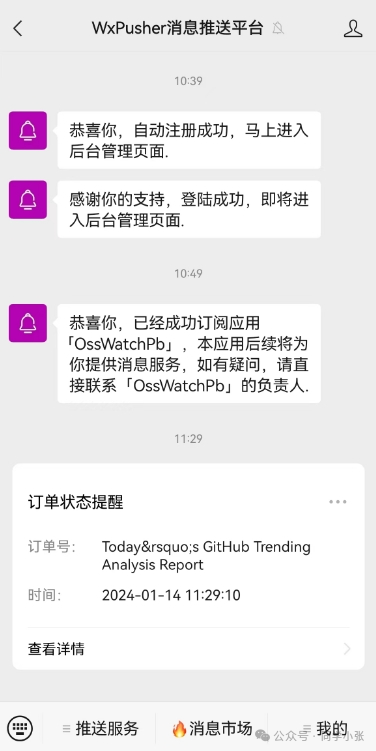
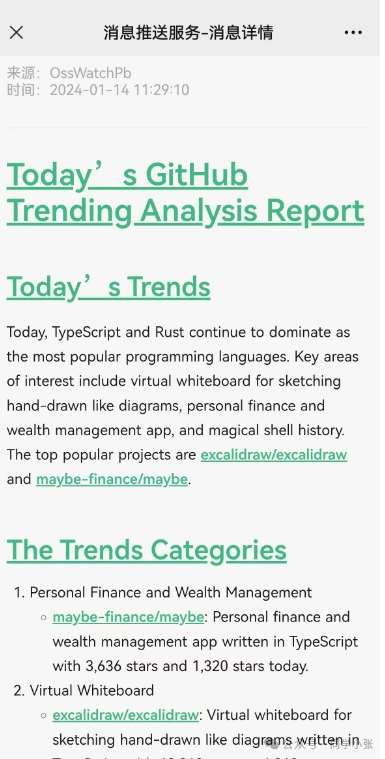